In [2]:
"""
%pip install qiskit==2.1.2
%pip install qiskit-ibm-runtime==0.41.1
%pip install qiskit-aer==0.17.2
%pip install pylatexenc
"""

'\n%pip install qiskit==2.1.2\n%pip install qiskit-ibm-runtime==0.41.1\n%pip install qiskit-aer==0.17.2\n%pip install pylatexenc\n'

In [3]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import  Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile
from math import pi

# Overview


This is a rather emblematic code. Shor's code, also known as the [[9, 1, 3]] code, was proposed by Peter Shor in 1995 and is a code capable of protecting a qubit against bit-flip and phase errors. The power of this code lies in the stabilizer properties we have already worked with and in the encoder stage. The encoder stage involves code concatenation, which involves embedding the output of one code into the input of another. Shor's code is also quite costly in terms of physical qubits. It requires 9 qubits to protect only one logical qubit and requires 8 ancilla qubits for syndrome extraction.


In this Jupyter notebook, we will implement the [[9, 1, 3]] code. The details of the experiment are quite similar to the details of other notebooks we have already worked with, such as the two-qubit code , the [[3, 1, 3]] code , and the [[4, 2, 2]] code. Again, we will create a noisy simulator model with quantum gates that will have errors. We will limit ourselves to 1-qubit gates with errors, and the only qubits that will experience errors are the qubits that encode the logical qubit. In other words, we will leave the ancilla qubits, responsible for detecting errors, error-free. We will also create custom gates to use as our stabilizers. Finally, we will implement the quantum circuit of the [[9, 1, 3]] code with the stage of creating the initial quantum state, the encoder stage, the stage of manipulating the logical state through a logical Pauli operator, the syndrome extraction stage, the error correction stage, and finally, the decoder stage.

The experiment we are going to perform is quite simple. However, it is very easy to get lost during the various quantum operations we will perform on the circuit. The main experiment is as follows: we create an initial quantum state, which will have an alpha% chance of obtaining ket 0 and a beta% chance of obtaining ket 1. The experiment will be conducted in a way that the chances of obtaining ket 0 and ket 1 are never equal; in other words, we will discard the ket plus state. After encoding to the logical state, we will apply a logical Pauli X gate, such that the probabilities will be swapped. At the end of the experiment, we should have an alpha% chance of obtaining ket 1 and a beta% chance of obtaining ket 0. Shor's code, of course, must protect our quantum state from any error that may occur.

# 1°: Create the Noisy Model

In the code cells below, we will create a noisy simulator map. We selected some basic gates that will contain noise, as well as the error probability. For didactic purposes, we apply the error map only to the logical qubits.

In [4]:
noise_model = NoiseModel()
p_error_1q = 0.01
noisy_gates = ['id', 'x', 'y', 'z', 'h']
error_1q = depolarizing_error(p_error_1q, 1)
for qubit in range(0, 9):
  noise_model.add_quantum_error(error_1q,  noisy_gates, [qubit])

# 2°: Create the Quantum State That Will be Protected by the Code

In this step, we create a quantum state that will be used to initialize the first qubit of the [[9, 1, 3]] circuit. We have worked with this quantum state before in the [[3, 1, 3]] error code. However, this version has a 75% probability of resulting in ket 0 and a 25% probability of resulting in ket 1. Our logical Pauli X operator must swap this probability to a 25% chance of obtaining ket 0 and a 75% chance of obtaining ket 1.

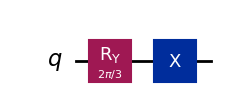

In [5]:
prep_circuit = QuantumCircuit(1)
prep_circuit.ry(2*pi/3, 0)
prep_circuit.x(0)
prep_circuit.draw("mpl")

In [6]:
quantum_state = Statevector(prep_circuit)
quantum_state.draw("latex")

<IPython.core.display.Latex object>

# 3°: Create the code stabilizers [[9, 1, 3]]

In the code cells below, we create the code stabilizers, which are necessary for syndrome detection and, consequently, error correction. We create custom gates for later use in the syndrome extraction stage of the quantum circuit.

In [7]:
# ZiZj Stabilizer Gate Creation
qr = QuantumRegister(2, 'qr')
qc = QuantumCircuit(qr)
qc.z(qr[:])
Z1Z2_stabilizer = qc.to_gate(label="Z1Z2").control(1)
Z2Z3_stabilizer = qc.to_gate(label="Z2Z3").control(1)
Z4Z5_stabilizer = qc.to_gate(label="Z4Z5").control(1)
Z5Z6_stabilizer = qc.to_gate(label="Z5Z6").control(1)
Z7Z8_stabilizer = qc.to_gate(label="Z7Z8").control(1)
Z8Z9_stabilizer = qc.to_gate(label="Z829").control(1)

In [8]:
# X1X2X3X4X5X6 and X4X5X6X7X8X9 Stabilizer Gate Creation
qr = QuantumRegister(6, 'qr')
qc = QuantumCircuit(qr)
qc.x(qr[:])
X1X2X3X4X5X6_stabilizer = qc.to_gate(label="X1X2X3X4X5X6").control(1)
X4X5X6X7X8X9_stabilizer = qc.to_gate(label="X4X5X6X7X8X9").control(1)

# 4°: Create the Error Code Circuit [[9, 1, 3]]

This is the longest and also the most complex part of the code. Below, we divide the Shor code circuit into 6 stages: quantum state initialization, the encoder stage, application of the logical Pauli X operator, syndrome extraction, error correction, and the decoder stage. Commonly, we were not adding the decoder stage in other examples of detection/correction codes we had been working with until now. This is because the measurement results were quite intuitive and it was easy to figure out what the logical qubit 0 and logical qubit 1 were. However, this is not an easy task in the Shor code; the multiple results and their interpretations are confusing. Therefore, we added the decoder stage to make it easier to understand

In [9]:
L = QuantumRegister(9, 'L')
A = QuantumRegister(8, 'A')
CL = ClassicalRegister(9, 'CL')
S = ClassicalRegister(8, 'S')
circuit = QuantumCircuit(L, A, CL, S)

In [10]:
# --- Psi State Initialization ---
circuit.initialize(quantum_state, L[0])
circuit.barrier(label="Psi Initialization")

# --- Encoder Procedure ---
# First Stage Of Enconder - Phase Flipping Encoding
circuit.cx(L[0], L[3])
circuit.cx(L[0], L[6])
circuit.h(L[0])
circuit.h(L[3])
circuit.h(L[6])

# Second Stage Of Enconder - Bit Flipping Encoding
circuit.cx(L[0], L[1])
circuit.cx(L[0], L[2])

circuit.cx(L[3], L[4])
circuit.cx(L[3], L[5])

circuit.cx(L[6], L[7])
circuit.cx(L[6], L[8])
circuit.barrier(label="Enconder Stage")
current_state = Statevector(circuit)
current_state.draw("latex")

<IPython.core.display.Latex object>

In [11]:
# --- Application of the X Logic Gate ---
circuit.z(L[:])
circuit.barrier(label="Application of the X Logic Gate ")

# --- Syndrome Extraction ---
circuit.h(A[:])
circuit.append(Z1Z2_stabilizer, [A[0], L[0], L[1]])
circuit.append(Z2Z3_stabilizer, [A[1], L[1], L[2]])
circuit.append(Z4Z5_stabilizer, [A[2], L[3], L[4]])
circuit.append(Z5Z6_stabilizer, [A[3], L[4], L[5]])
circuit.append(Z7Z8_stabilizer, [A[4], L[6], L[7]])
circuit.append(Z8Z9_stabilizer, [A[5], L[7], L[8]])

circuit.append(X1X2X3X4X5X6_stabilizer, [A[6], L[0], L[1], L[2], L[3], L[4], L[5]])
circuit.append(X4X5X6X7X8X9_stabilizer, [A[7], L[3], L[4], L[5], L[6], L[7], L[8]])
circuit.h(A[:])
circuit.measure(A[:], S[:])
circuit.barrier(label="Syndrome Extraction")

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=17, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "L"), index=0>, <Qubit register=(9, "L"), index=1>, <Qubit register=(9, "L"), index=2>, <Qubit register=(9, "L"), index=3>, <Qubit register=(9, "L"), index=4>, <Qubit register=(9, "L"), index=5>, <Qubit register=(9, "L"), index=6>, <Qubit register=(9, "L"), index=7>, <Qubit register=(9, "L"), index=8>, <Qubit register=(8, "A"), index=0>, <Qubit register=(8, "A"), index=1>, <Qubit register=(8, "A"), index=2>, <Qubit register=(8, "A"), index=3>, <Qubit register=(8, "A"), index=4>, <Qubit register=(8, "A"), index=5>, <Qubit register=(8, "A"), index=6>, <Qubit register=(8, "A"), index=7>), clbits=())

In [12]:
# --- Error Correction Stage ---

with circuit.switch(S) as case:
    # Bit Flip Error Correction
    # Error X1 (S=00000001)
    with case(1): circuit.x(L[0])

    # Error X2 (S=00000011)
    with case(3): circuit.x(L[1])

    # Error X3 (S=00000010)
    with case(2): circuit.x(L[2])

    # Error X4 (S=00000100)
    with case(4): circuit.x(L[3])

    # Error X5 (S=00001100)
    with case(12): circuit.x(L[4])

    # Error X6 (S=00001000)
    with case(8): circuit.x(L[5])

    # Error X7 (S=00010000)
    with case(16): circuit.x(L[6])

    # Error X8 (S=00110000)
    with case(48): circuit.x(L[7])

    # Error X9 (S=00100000)
    with case(32): circuit.x(L[8])

    # Phase Flip Error Correction
    # Error Z1, Z2 or Z3 (S=01000000)
    with case(64): circuit.z(L[0])

    # Error Z4, Z5 or Z6 (S=11000000)
    with case(192): circuit.z(L[3])

    # Error Z7, Z8 or Z9 (S=10000000)
    with case(128): circuit.z(L[6])

circuit.barrier(label="Error Correction Stage")

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=17, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "L"), index=0>, <Qubit register=(9, "L"), index=1>, <Qubit register=(9, "L"), index=2>, <Qubit register=(9, "L"), index=3>, <Qubit register=(9, "L"), index=4>, <Qubit register=(9, "L"), index=5>, <Qubit register=(9, "L"), index=6>, <Qubit register=(9, "L"), index=7>, <Qubit register=(9, "L"), index=8>, <Qubit register=(8, "A"), index=0>, <Qubit register=(8, "A"), index=1>, <Qubit register=(8, "A"), index=2>, <Qubit register=(8, "A"), index=3>, <Qubit register=(8, "A"), index=4>, <Qubit register=(8, "A"), index=5>, <Qubit register=(8, "A"), index=6>, <Qubit register=(8, "A"), index=7>), clbits=())

In [13]:
# --- Decoder Procedure ---
# First Stage Of Decoder - Undoing the Bit-Flip Encoding
circuit.cx(L[6], L[8])
circuit.cx(L[6], L[7])

circuit.cx(L[3], L[5])
circuit.cx(L[3], L[4])

circuit.cx(L[0], L[2])
circuit.cx(L[0], L[1])

# Second Stage Of Decoder - Undoing the Phase-Flip Encoding
circuit.h(L[6])
circuit.h(L[3])
circuit.h(L[0])
circuit.cx(L[0], L[6])
circuit.cx(L[0], L[3])
circuit.barrier(label="Decoder Stage")

# --- Measurements of Logical Qubits ---
circuit.measure(L[:], CL[:])

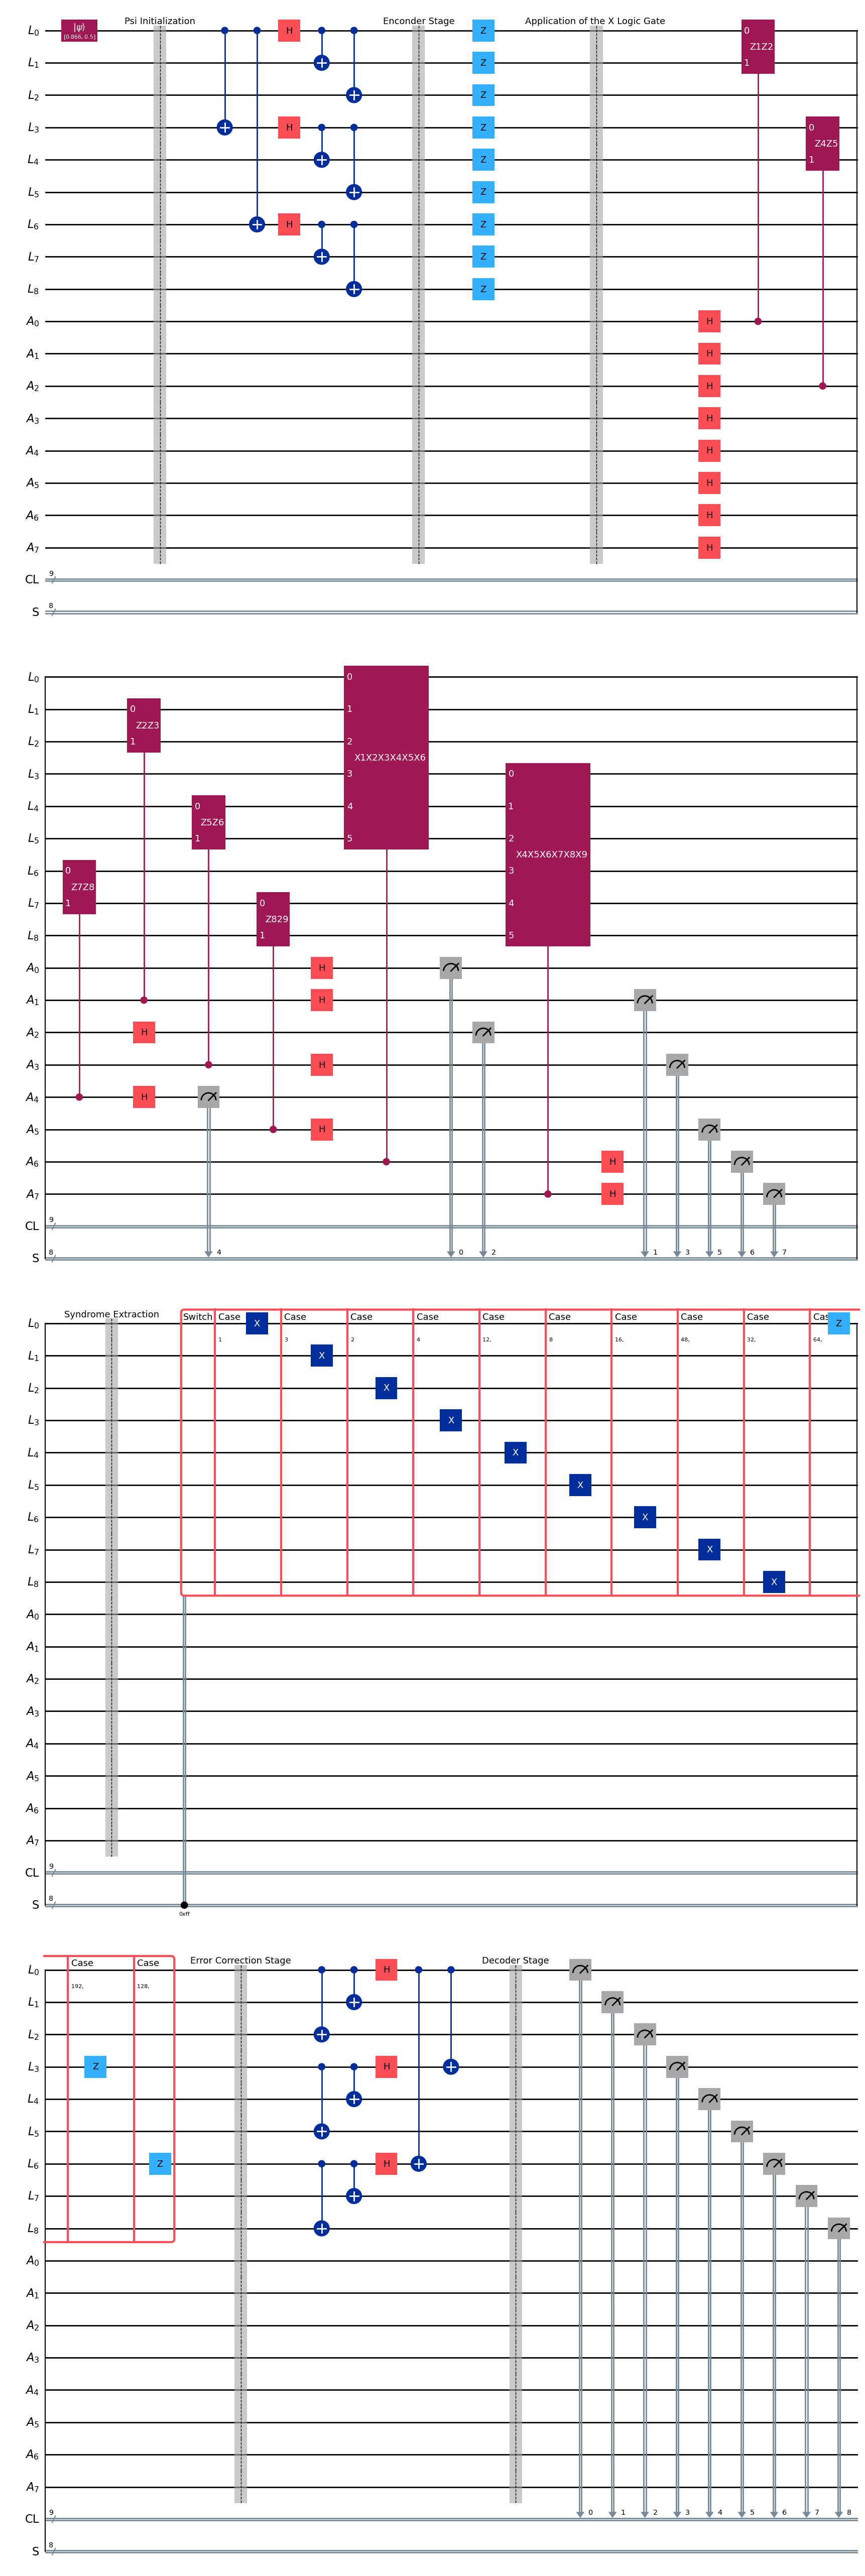

In [14]:
circuit.draw(output='mpl')

# 5°: Results View

Upon finishing this experiment, we constructed two histograms: The first histogram shows the bitstring results of the 9 qubits we used to encode the logical qubit, while the second histogram shows only the bitstring results of the 9 qubits with the syndrome qubits correctly detected and corrected back to the codespace. Of course, the quantity of results is much larger than what is shown by the two histograms. However, for didactic purposes and quick comprehension of the experiment, we limited ourselves only to these two histograms. We also conducted a test to verify the success rate of the Shor code. It is possible to verify through the histograms that the result of applying the logical Pauli X operator was successful. We managed to reverse the probability distributions between Ket 0 and Ket 1.

In [15]:
sim_noise = AerSimulator(noise_model=noise_model)
shots = 1024
trp_circuit = transpile(circuit, sim_noise)
sim_noise_run = sim_noise.run(trp_circuit, shots=shots)
counts = sim_noise_run.result().get_counts()

In [16]:
bitstrings_count = {}
for bitstring, count in counts.items():
  new_bitstring = bitstring[-9:]
  bitstrings_count[new_bitstring] = bitstrings_count.get(new_bitstring, 0) + count

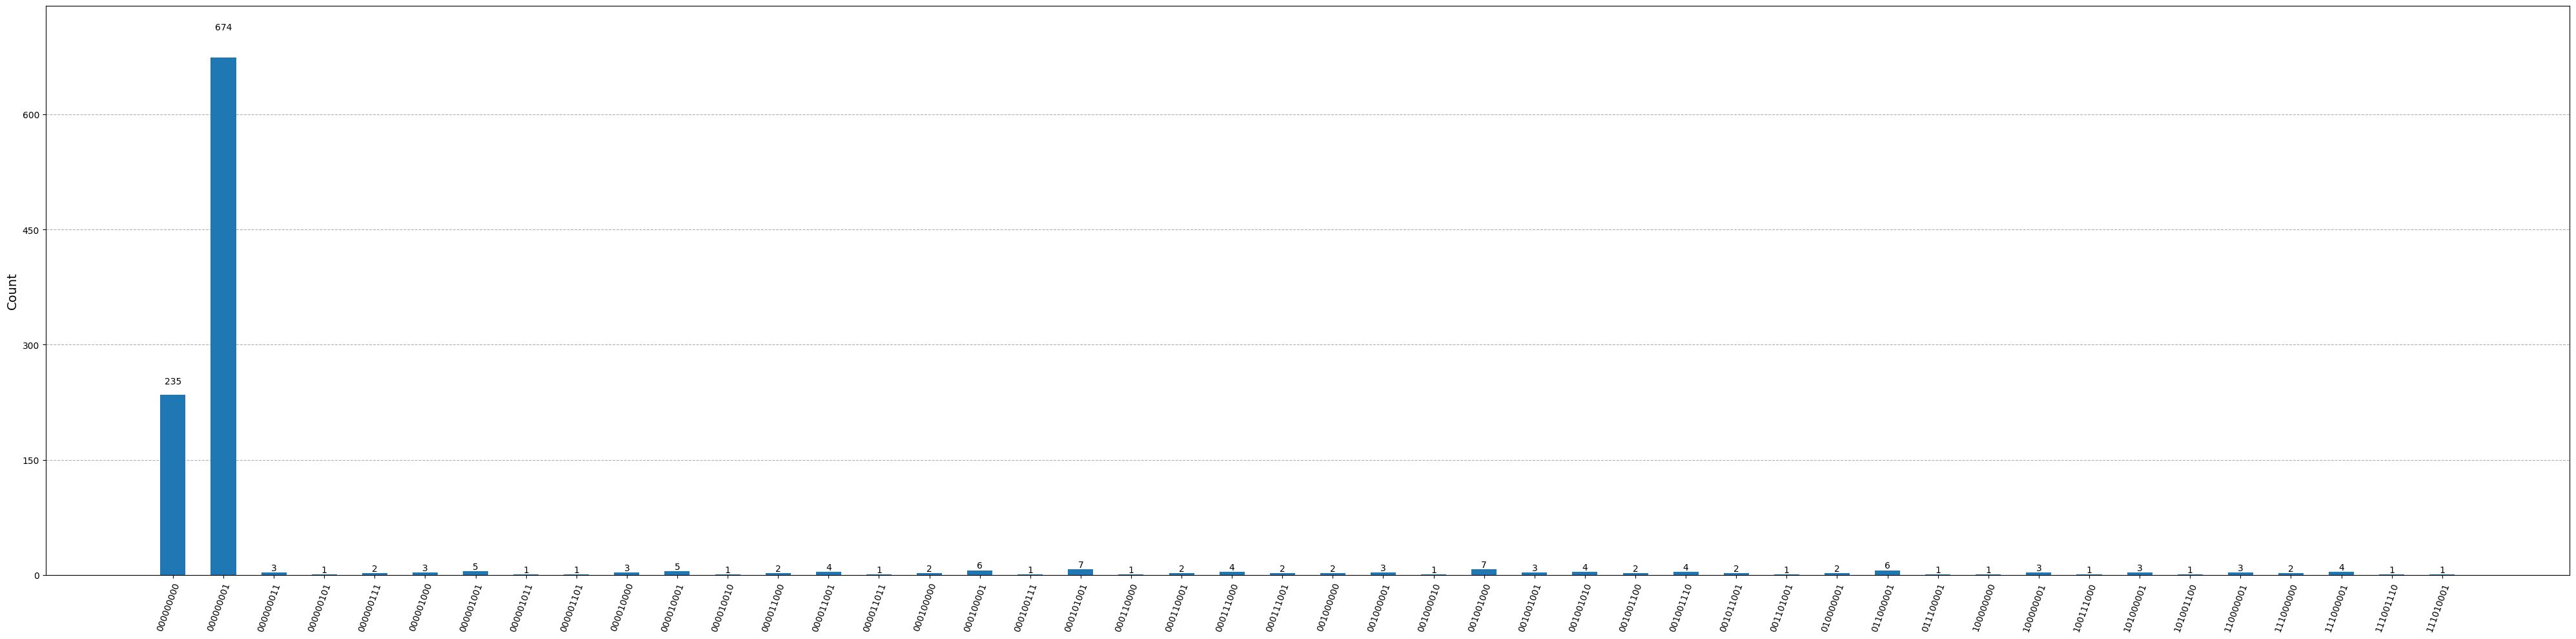

In [17]:
plot_histogram(bitstrings_count, figsize=(40, 10))

In [18]:
new_counts = {}
for bitstring, count in counts.items():
  if bitstring[-9:] == '000000000' or bitstring[-9:] == '000000001':
    new_counts[bitstring] = count

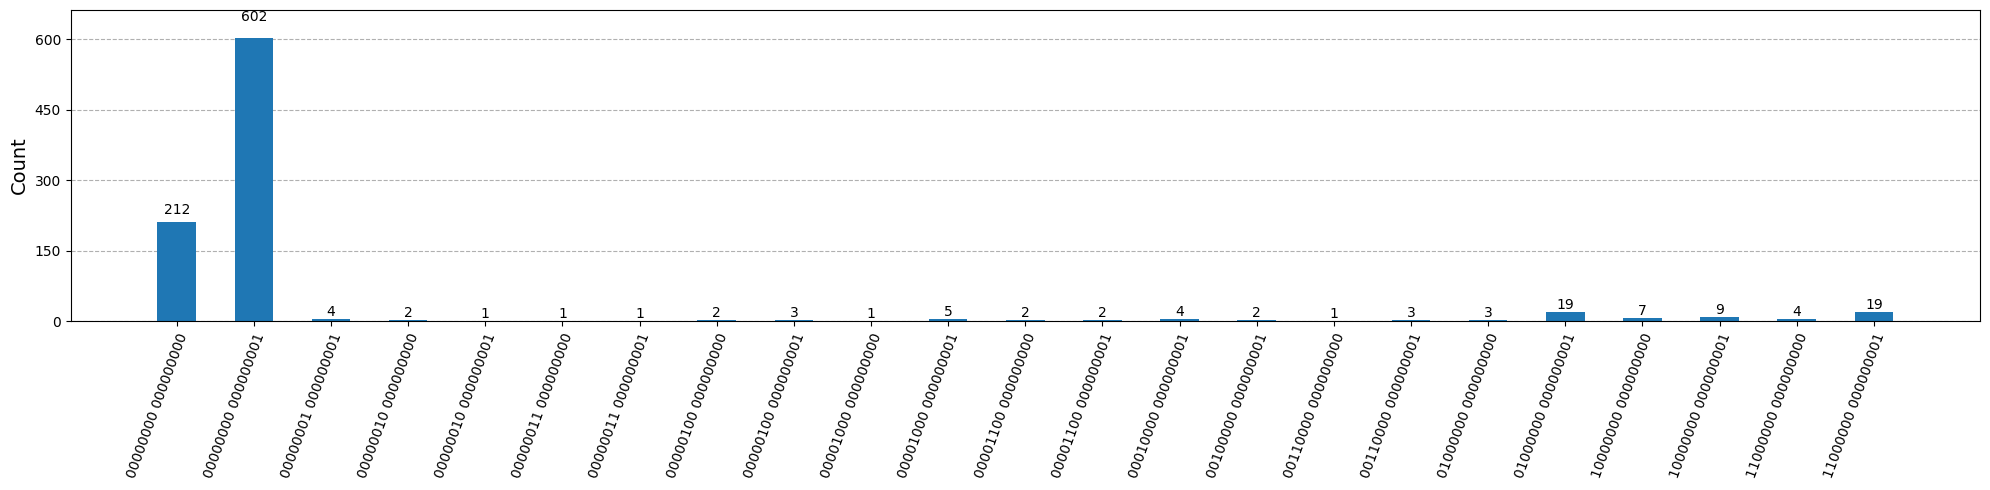

In [19]:
plot_histogram(new_counts, figsize=(20, 5))

In [21]:
ecc_hit_rate = 0

for bitstring, count in counts.items():
  if bitstring.endswith('000000000') or bitstring.endswith('000000001'):
    ecc_hit_rate += count

In [22]:
ecc_hit_rate = ecc_hit_rate*100/shots

print("General Data of The Experiment: ")
print(f"With ECC Hit Rate: {ecc_hit_rate:.2f}%")

General Data of The Experiment: 
With ECC Hit Rate: 88.77%
